In [1]:
#Based on tutorial: https://machinelearningmastery.com/random-forest-ensemble-in-python/
#Run this code before you can classify

# Use numpy to convert to arrays
import numpy as np
from numpy import mean, std

# Pandas is used for data manipulation
import pandas as pd

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the models we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

#Import mathplotlib for plotting
import matplotlib.pyplot as plt

#load in the dataset
features = pd.read_csv('heloc_dataset_v4.csv')
feature_names = features.columns

#the columns that stores the labels
labelDimension = "RiskPerformance"
feature_names = feature_names.drop(labelDimension)

# Labels are the values we want to predict
labels = np.array(features[labelDimension])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(labelDimension, axis = 1)

# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets (heavily overfit on provided dataset to get as close as possible to the original model)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.30)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


def build_rf_model(train_features, train_labels, features, labels):

    # Instantiate model with 1500 decision trees
    rf = RandomForestClassifier(n_estimators = 1500)
    # Train the model on training data
    rf.fit(train_features, train_labels)

    #evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
    n_scores = cross_val_score(rf, features, labels, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    print("done!")
    print("evaluating:")

    # report performance
    print(n_scores)
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    return rf

Training Features Shape: (6777, 17)
Training Labels Shape: (6777,)
Testing Features Shape: (2905, 17)
Testing Labels Shape: (2905,)


In [2]:
#build a random forest classifier
rf_model = build_rf_model(train_features, train_labels, features, labels)

# Save the model to disk
import pickle
import os

filename = os.path.join("../models/MainModel.pkl")
pickle.dump(rf_model, open(filename, 'wb'))

done!
evaluating:
[0.72755418 0.7120743  0.75       0.70867769 0.71694215 0.70661157
 0.72107438 0.72830579 0.73657025 0.71590909]
Accuracy: 0.722 (0.013)


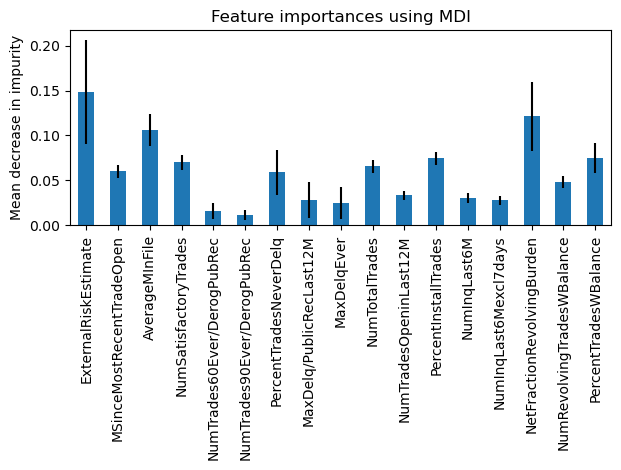

In [3]:
importances = rf_model.feature_importances_
stdx = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=stdx, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [4]:
# #get the first datarow of the dataset
# row = features.loc[0,:]

# #remove the label column (first column)
# instance = row[1:len(row)]

# # Use the forest's predict method on the test data
# prediction = rf_model.predict(instance.to_numpy().reshape(1,-1))

# #print prediction
# print(prediction)

In [5]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)
features_scaled = scaler.transform(features)

In [6]:
def build_kNN_model(train_features, train_labels, features, labels, n_neighbors):

    # Instantiate model with 5 neighbors
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    # Train the model on training data
    knn.fit(train_features, train_labels)

    #evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
    n_scores = cross_val_score(knn, features, labels, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    print("done!")
    print("evaluating:")

    # report performance
    print(n_scores)
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    return knn

In [7]:
#build a kNN
rf_model = build_rf_model(train_features, train_labels, features, labels)

done!
evaluating:
[0.71620227 0.74303406 0.74586777 0.73553719 0.71797521 0.72623967
 0.7107438  0.71384298 0.68698347 0.75413223]
Accuracy: 0.725 (0.019)


In [8]:
knn = build_kNN_model(train_features_scaled, train_labels, features_scaled, labels, n_neighbors=14)

done!
evaluating:
[0.70485036 0.71517028 0.71694215 0.70867769 0.72210744 0.70764463
 0.71280992 0.70454545 0.72727273 0.71177686]
Accuracy: 0.713 (0.007)


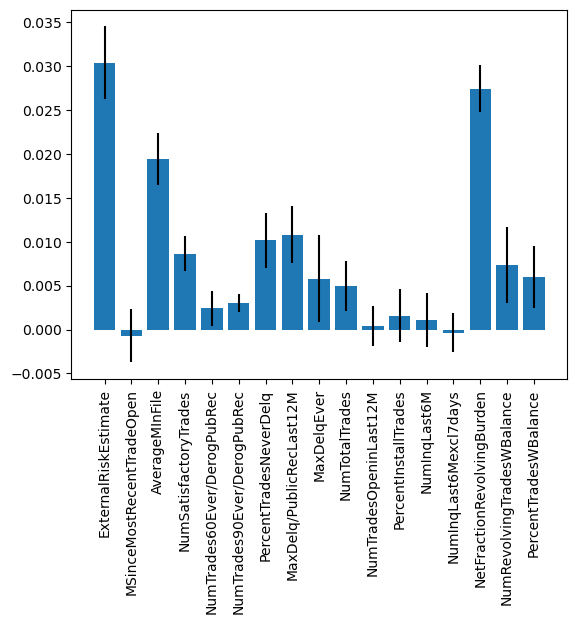

In [9]:
from sklearn.inspection import permutation_importance

# Assuming knn is your trained model
result = permutation_importance(knn, test_features_scaled, test_labels, n_repeats=10)
# Get importance and corresponding standard deviations
importances = result.importances_mean
std_devs = result.importances_std
# Plot feature importance
plt.bar(range(features.shape[1]), importances, yerr=std_devs)
plt.xticks(ticks=range(features.shape[1]), labels=feature_names, rotation=90)
plt.show()


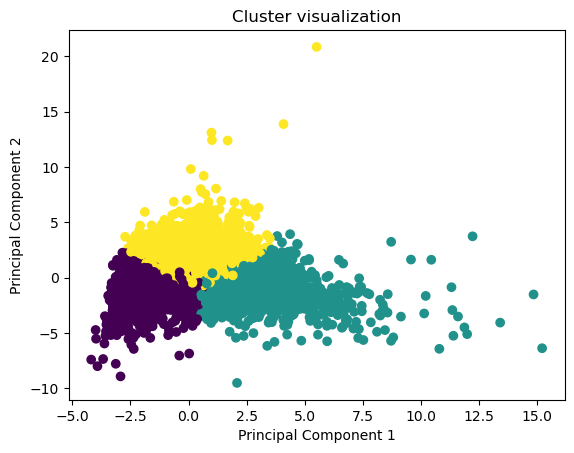

In [10]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3)  # You can change the number of clusters based on your analysis
clusters = kmeans.fit_predict(features_scaled)  # Make sure to use scaled data

# Visualize the clusters (assuming you have a 2D PCA for visualization)
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principal_components = pca.fit_transform(features_scaled)
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster visualization')
plt.show()

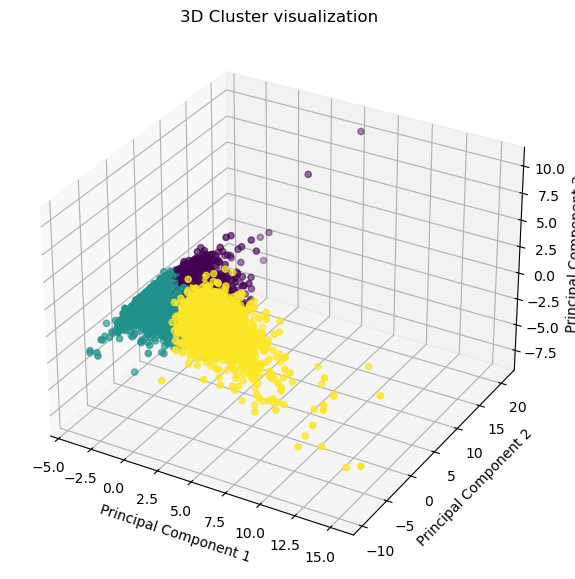

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3)  # You can change the number of clusters based on your analysis
clusters = kmeans.fit_predict(features_scaled)  # Make sure to use scaled data

# Perform PCA with 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(features_scaled)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=clusters)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D Cluster visualization')
plt.show()